This notebook shows the yelp dataset start rating classification problem. The objective is to predict the star rating based on photos

In [1]:
!pip install --upgrade tensorflow
!pip install pillow
!pip install h5py
!pip install keras

    100% |████████████████████████████████| 92.6MB 415kB/s eta 0:00:01
    100% |████████████████████████████████| 102kB 15.0MB/s a 0:00:01
    100% |████████████████████████████████| 61kB 11.8MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 15.8MB/s ta 0:00:01
    100% |████████████████████████████████| 2.2MB 10.4MB/s ta 0:00:01
    100% |████████████████████████████████| 3.2MB 11.7MB/s ta 0:00:01 2% |▊                               | 71kB 9.0MB/s eta 0:00:01    73% |███████████████████████▌        | 2.3MB 19.4MB/s eta 0:00:01
    100% |████████████████████████████████| 368kB 16.7MB/s ta 0:00:01
    100% |████████████████████████████████| 337kB 28.6MB/s ta 0:00:01
    100% |████████████████████████████████| 92kB 21.9MB/s ta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
  Stored in directory: /home/jovyan/.cache/pip/wheels/ee/98/38/46cbcc5a93cfea5492d19c38562691ddb23b940176c14f7b48
  Stored in d

In [1]:
import json
import seaborn as sns
import pandas as pd
import numpy as np
import itertools
import operator
from random import shuffle
import os, sys
from PIL import Image

import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
#sns.set_style('darkgrid')


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, precision_recall_curve, precision_score, recall_score, average_precision_score 

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
from keras.layers.normalization import BatchNormalization
from keras import callbacks, applications, optimizers

import warnings
warnings.filterwarnings("ignore")
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

#from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8")) #check the files available in the directory

np.random.seed(42)

Using TensorFlow backend.


## 1. Load Data

In [2]:
df_business = pd.read_json('../../data/business.json',lines=True)
df_photo = pd.read_json('../../data/photo.json', lines=True)

## 2. Exploratory Data Analysis (EDA) and Data Preprocessing

In [3]:
df_business.dropna(inplace=True)
df_business['review_count'] = df_business['review_count'].fillna(0)
df_business['stars'] = round(df_business['stars'].fillna(0)).apply(int)

In [4]:
df_business.shape

(129268, 14)

In [5]:
list_starts = df_business['stars'].unique()

In [6]:
list_starts

array([2, 4, 5, 3, 1])

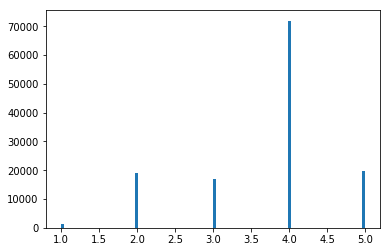

In [7]:
plt.hist(df_business['stars'].tolist(), bins='auto')  
plt.show()

In [8]:
df_business.describe()

,is_open,latitude,longitude,review_count,stars
count,129268.000,129268.000,129268.000,129268.000,129268.000
mean,0.844,38.348,-97.977,44.508,3.693
std,0.363,4.868,16.626,131.780,0.939
min,0.000,33.205,-115.478,3.000,1.000
25%,1.000,33.626,-112.273,6.000,3.000
50%,1.000,36.128,-111.791,13.000,4.000
75%,1.000,43.113,-80.037,36.000,4.000
max,1.000,51.297,-72.945,8348.000,5.000


In [9]:
df_photo.shape

(200000, 4)

In [10]:
df_photo.describe()

,business_id,caption,label,photo_id
count,200000,200000,200000,200000
unique,30488,71513,5,200000
top,RESDUcs7fIiihp38-d6_6g,,food,fJ0_aFMYSN6qLu1vHjlQDQ
freq,823,107850,114874,1


In [11]:
df_photo.head()

,business_id,caption,label,photo_id
0,rcaPajgKOJC2vo_l3xa42A,,inside,MllA1nNpcp1kDteVg6OGUw
1,Kn23LDd740SBVJ7mum0fwg,,inside,YjxBE88Bf6CmTEF2LP1UNA
2,ZkGDCVKSdf8m76cnnalL-A,,food,1f7izSjM0WjkDRIVbPy1yw
3,bF8gv7k_rwZtiDLP2ZB04w,,inside,NcSlcDTEEeOaixotOPk-rA
4,50Anorn0DJXFhBr9a9_gHQ,,inside,5IiIo5UKEW0lWqZ6sWrY_A


In [32]:
len(df_photo['business_id'].unique())

30488

In [12]:
df_photo['caption'].describe()

count     200000
unique     71513
top             
freq      107850
Name: caption, dtype: object

In [14]:
len(df_photo['caption'].unique())

71513

In [15]:
df_merged = pd.merge(df_business, df_photo, on='business_id', how='left')

In [16]:
df_merged.shape

(291092, 17)

- **Due to limited computational resources, randomly select some samples from the dataframe**

In [17]:
df_merged_new = df_merged.sample(frac=0.002, replace=False, random_state=42)

In [18]:
df_merged_new.shape

(582, 17)

In [19]:
df_merged_new.dropna(inplace=True)

In [20]:
df_merged_new.shape

(377, 17)

In [21]:
df_merged_new.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state,caption,label,photo_id
130799,"335 N Gilbert Rd, Ste 102","{'BusinessParking': '{'garage': False, 'street...",Ph02ztlom5e4IJkty2bWpg,"Food, Gastropubs, Breakfast & Brunch, Brewerie...",Gilbert,"{'Monday': '11:0-0:0', 'Tuesday': '11:0-0:0', ...",1,33.356,-111.789,OHSO Gilbert,85234,209,4,AZ,,food,HQr4-XdhWUIBBHPgzhBq1w
183121,3957 S Maryland Pkwy,"{'HasTV': 'True', 'WiFi': 'u'free'', 'Business...",cePE3rCuUOVSCCAHSjWxoQ,"Fast Food, Restaurants, Sandwiches, American (...",Las Vegas,"{'Monday': '0:0-0:0', 'Tuesday': '11:0-20:0', ...",1,36.117,-115.138,Karved,89119,313,5,NV,Inside,inside,3bNJKTGIWOkViwd_38X4fg
270559,295 Carowinds Blvd,"{'GoodForMeal': '{'dessert': False, 'latenight...",3GMgxgK11TqpQq8TWh_7uA,"Caterers, Southern, Comfort Food, Breakfast & ...",Fort Mill,"{'Monday': '6:0-22:0', 'Tuesday': '6:0-22:0', ...",1,35.095,-80.939,Cracker Barrel Old Country Store,29708,80,2,SC,,inside,jJgmqqsSurxUS96vLDMnnw
78917,5051 Bayfield Pkwy,"{'BusinessAcceptsCreditCards': 'True', 'Alcoho...",z7qbndwc9lH9hOR5N8ORiA,"Restaurants, Fast Food, Food, Coffee & Tea, Bu...",Kannapolis,"{'Monday': '5:0-1:0', 'Tuesday': '5:0-1:0', 'W...",1,35.420,-80.676,McDonald's,28027,13,2,NC,,food,g7qR4sfH0kG3BVF4Nf2WEg
139450,"6751 N Sunset Blvd, Ste E-113","{'GoodForKids': 'False', 'BusinessAcceptsCredi...",j81gE7OU9gh53SMCHvYeHg,"Sandwiches, American (New), Bars, Nightlife, P...",Glendale,"{'Monday': '11:0-2:0', 'Tuesday': '11:0-2:0', ...",1,33.533,-112.262,Fat Tuesday,85305,33,4,AZ,,drink,jRALfTTCi3RVBlUgbnHJXw


In [22]:
list_photo_ids = df_merged_new['photo_id'].values

In [23]:
df_merged_new['photo_id'].values[0]

'HQr4-XdhWUIBBHPgzhBq1w'

In [24]:
im = Image.open('../../data/yelp_photos/photos/{}.jpg'.format(df_merged_new['photo_id'].values[0])) 


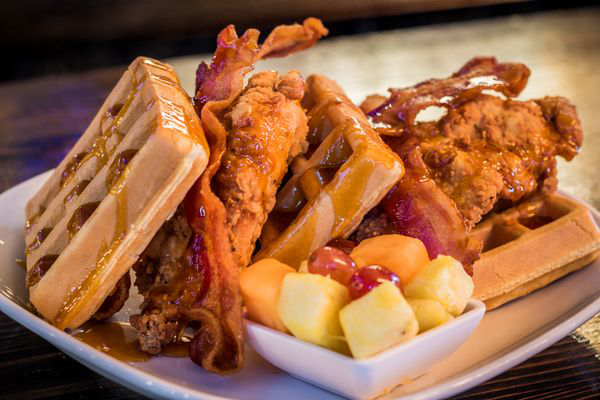

In [25]:
im

In [26]:
im.size

(600, 400)

In [27]:
im = Image.open('../../data/yelp_photos/photos/{}.jpg'.format(df_merged_new['photo_id'].values[1])) 


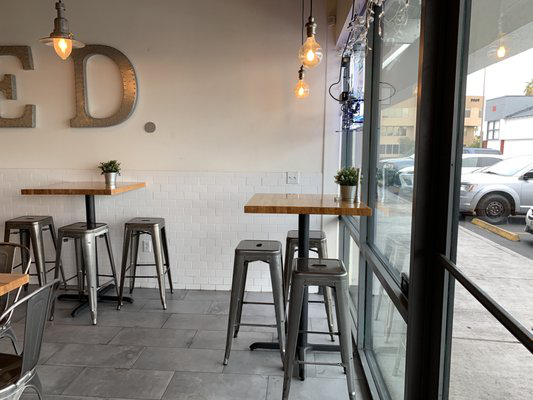

In [28]:
im

In [29]:
im.size

(533, 400)

- test image resize function

In [30]:
im1 = Image.open('../../data/yelp_photos/photos/{}.jpg'.format(df_merged_new['photo_id'].values[1]))
# adjust width and height to your needs
width = 128
height = 128
# use one of these filter options to resize the image
#im2 = im1.resize((width, height), Image.NEAREST)      # use nearest neighbour
#im3 = im1.resize((width, height), Image.BILINEAR)     # linear interpolation in a 2x2 environment
#im4 = im1.resize((width, height), Image.BICUBIC)      # cubic spline interpolation in a 4x4 environment
im5 = im1.resize((width, height), Image.ANTIALIAS)    # best down-sizing filter


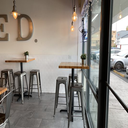

In [31]:
im5

## 3. Modeling

- Prepare train and test sets

Note: in this use case, I only take one image per hotel. 

In [111]:
class_names = list_starts

# Note due to computation cost images are resized to smaller sizes
# img_width, img_height = 80, 80
img_width, img_height = 100, 100

img_x = []
img_y = []

# ------------
# Get training and test images

img_dir_path = "../../data/yelp_photos/photos/"
#dirs = os.listdir(img_dir_path)

# key: product id, value: image path
dict_img_path = dict()

for photo_id in list(list_photo_ids):
#for file_name in dirs:
#    file_path = os.path.join(img_dir_path, file_name)
    file_path = '{}/{}.jpg'.format(img_dir_path, photo_id)
    img = load_img(file_path)         # this is a PIL image
    img_resize = img.resize((img_width, img_height), Image.ANTIALIAS)
    x = img_to_array(img_resize)      # this is a Numpy array with shape (img_width, img_height, 3)
    # x = x.reshape((1,) + x.shape)   # this is a Numpy array with shape (1, 3, img_width, img_height)
    
    img_x.append(x)
    
    y = df_merged_new[df_merged_new['photo_id']==photo_id]['stars'].values[0]
    img_y.append(y)
    
    
#combined = list(zip(img_x, img_y))
#random.shuffle(combined)
#img_x[:], img_y[:] = zip(*combined)
#train_img_x = img_x[:round(0.7*len(list_photo_ids))]
#train_img_y = img_y[:round(0.7*len(list_photo_ids))]
#test_img_x = img_x[round(0.7*len(list_photo_ids)):]
#test_img_y = img_y[round(0.7*len(list_photo_ids)):]


train_img_x, test_img_x, train_img_y, test_img_y = train_test_split(img_x, img_y, test_size=0.3, random_state=42)

train_img_x = np.array(train_img_x).astype(np.uint8)
train_img_y = np.array(train_img_y)
test_img_x = np.array(test_img_x).astype(np.uint8)
test_img_y = np.array(test_img_y)

print(train_img_x.shape)
print(train_img_y.shape)
print(test_img_x.shape)
print(test_img_y.shape)

(263, 100, 100, 3)
(263,)
(114, 100, 100, 3)
(114,)


In [112]:
img = Image.fromarray(train_img_x[0], 'RGB')

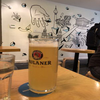

In [113]:
img

- Prepare label, i.e., int to one-hot encoding

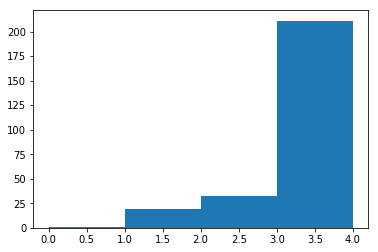

{0, 1, 2, 3, 4}


In [114]:
# ----------
# Transform category to one-hot encoding

le = preprocessing.LabelEncoder()
le.fit(class_names)
train_img_y = le.transform(train_img_y)
test_img_y = le.transform(test_img_y)
test_true_classes = test_img_y

plt.hist(train_img_y.tolist(), range(min(train_img_y), max(train_img_y)+1))
plt.show()
print(set(train_img_y))

#plt.hist(test_img_y.tolist(), range(min(test_img_y), max(test_img_y)+1))
#plt.show()
#print(set(test_img_y))

In [115]:
train_img_y = to_categorical(train_img_y, num_classes = len(class_names))
test_img_y = to_categorical(test_img_y, num_classes = len(class_names))

# Split the train and the validation set for the fitting
train_img_x, val_img_x, train_img_y, val_img_y = train_test_split(train_img_x, train_img_y, test_size = 0.1, random_state=42)

print('train set shape')
print(np.array(train_img_x).shape)
print(np.array(train_img_y).shape)
print('validation set shape')
print(np.array(val_img_x).shape)
print(np.array(val_img_y).shape)

train set shape
(236, 100, 100, 3)
(236, 5)
validation set shape
(27, 100, 100, 3)
(27, 5)


In [116]:
# ----------------------
# CNN hyperparameters

epochs = 60
batch_size = 64
filters = [16, 8]
kernel_sizes = [5, 5]
strides = [2, 2]
pooling_sizes = [2]

str_parameters = '[epochs]{}-[batch_size]{}-[filters]{}-[kernel_sizes]{}-[strides]{}-[pooling_sizes]{}'.format(epochs,
                                                                                                                batch_size,
                                                                                                                '_'.join(str(x) for x in filters),
                                                                                                                '_'.join(str(x) for x in kernel_sizes),
                                                                                                                '_'.join(str(x) for x in strides),
                                                                                                                '_'.join(str(x) for x in pooling_sizes),
                                                                                                                )

model_name = 'CNN' 
#model_name = 'VGG16'  # require GPU

In [117]:
# ----------------
# Define the CNN models

model = None
if model_name == 'CNN':
    model = Sequential()

    model.add(Conv2D(filters = filters[0], kernel_size = (kernel_sizes[0], kernel_sizes[0]),
                     padding = 'Same', strides=strides[0],  input_shape = (img_width, img_height, 3)),
                     #activation ='relu',
                    )
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Conv2D(filters = filters[1], kernel_size = (kernel_sizes[1], kernel_sizes[1]),
                     padding = 'Same', strides=strides[1],
                     #activation ='relu'
                     ))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(MaxPool2D(pool_size=(pooling_sizes[0], pooling_sizes[0])))
    model.add(Dropout(0.2))

    model.add(Flatten())
    #model.add(Dense(256, activation = "relu"))
    model.add(Dense(128, kernel_initializer='glorot_uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    model.add(Dense(len(class_names), activation = "softmax"))

elif model_name == 'VGG16':
    # use pre-trained VGG16
    base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

    add_model = Sequential()
    add_model.add(Flatten(input_shape=base_model.output_shape[1:]))

    add_model.add(Dense(256, kernel_initializer='glorot_uniform'))
    # add_model.add(Dense(1, activation='sigmoid'))
    add_model.add(BatchNormalization())
    add_model.add(Activation('relu'))
    add_model.add(Dropout(0.2))

    add_model.add(Dense(len(class_names), activation="softmax"))

    model = Model(inputs=base_model.input, outputs=add_model(base_model.output))

    # model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
    #              metrics=['accuracy'])

print(model.summary())

optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
#optimizer = optimizers.SGD(lr=1e-3, momentum=0.9) 

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=2,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 50, 50, 16)        1216      
_________________________________________________________________
batch_normalization_7 (Batch (None, 50, 50, 16)        64        
_________________________________________________________________
activation_7 (Activation)    (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 25, 25, 8)         3208      
_________________________________________________________________
batch_normalization_8 (Batch (None, 25, 25, 8)         32        
_________________________________________________________________
activation_8 (Activation)    (None, 25, 25, 8)         0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 8)         0         
__________

In [118]:
# -----------
# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,               # set input mean to 0 over the dataset
        samplewise_center=False,                # set each sample mean to 0
        featurewise_std_normalization=False,    # divide inputs by std of the dataset
        samplewise_std_normalization=False,     # divide each input by its std
        zca_whitening=False,                    # apply ZCA whitening
        rotation_range=10,                      # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1,                       # randomly zoom image
        width_shift_range=0.1,                  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,                 # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,                  # randomly flip images
        vertical_flip=False)                    # randomly flip images

datagen.fit(train_img_x)

Epoch 1/60
 - 3s - loss: 1.3857 - acc: 0.4635 - val_loss: 1.5423 - val_acc: 0.2963
Epoch 2/60
 - 1s - loss: 0.9975 - acc: 0.5893 - val_loss: 1.1929 - val_acc: 0.5926
Epoch 3/60
 - 1s - loss: 0.8934 - acc: 0.7375 - val_loss: 1.2500 - val_acc: 0.5556
Epoch 4/60
 - 1s - loss: 0.8121 - acc: 0.7429 - val_loss: 0.9829 - val_acc: 0.5556

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/60
 - 1s - loss: 0.7391 - acc: 0.7604 - val_loss: 0.9802 - val_acc: 0.6667
Epoch 6/60
 - 1s - loss: 0.6254 - acc: 0.8143 - val_loss: 0.9758 - val_acc: 0.7037
Epoch 7/60
 - 1s - loss: 0.6121 - acc: 0.8125 - val_loss: 0.9517 - val_acc: 0.7037
Epoch 8/60
 - 1s - loss: 0.6383 - acc: 0.7803 - val_loss: 1.0213 - val_acc: 0.6296

Epoch 00008: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 9/60
 - 1s - loss: 0.6424 - acc: 0.8073 - val_loss: 1.0133 - val_acc: 0.6667
Epoch 10/60
 - 1s - loss: 0.6171 - acc: 0.8107 - val_loss: 0.9556 - val_acc: 0.6296

Epoch 

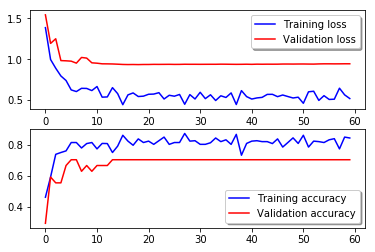

In [119]:
# -------------
# Train the CNN model
history = model.fit_generator(datagen.flow(train_img_x, train_img_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (val_img_x, val_img_y),
                              verbose = 2, 
                              steps_per_epoch=train_img_x.shape[0] // batch_size, 
                              callbacks=[learning_rate_reduction])


# Training and validation curves
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


plt.show()

In [120]:
# Save the model
model_dir = './models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

model_path = ''
if model_name == 'CNN':
    model_path = '{}cat-cnn-model-{}.h5'.format(model_dir, str_parameters)
elif model_name == 'VGG16':
    model_path = '{}cat-vgg16-{}-{}.h5'.format(model_dir, epochs, batch_size)
model.save(model_path)
print('save model to {}'.format(model_path))

model_weights_path = ''
if model_name == 'CNN':
    model_weights_path = '{}cat-cnn-weights-{}.h5'.format(model_dir, str_parameters)
elif model_name == 'VGG16':
    model_weights_path = '{}cat-vgg16-weights-{}-{}.h5'.format(model_dir, epochs, batch_size)
model.save_weights(model_weights_path)
print('save weights to {}'.format(model_weights_path))

save model to ./models/cat-cnn-model-[epochs]60-[batch_size]64-[filters]16_8-[kernel_sizes]5_5-[strides]2_2-[pooling_sizes]2.h5
save weights to ./models/cat-cnn-weights-[epochs]60-[batch_size]64-[filters]16_8-[kernel_sizes]5_5-[strides]2_2-[pooling_sizes]2.h5


In [121]:
model = load_model(model_path)
model.load_weights(model_weights_path)

test_pred = model.predict(test_img_x)

In [122]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# convert predictions classes to one hot vectors
test_pred_classes = np.argmax(test_pred, axis = 1)
# results = pd.Series(test_pred_classes, name="Label")

# convert test observations to one hot vectors
test_true_classes = np.argmax(test_img_y, axis = 1)

acc_score = accuracy_score(test_true_classes, test_pred_classes)
print('accuracy {}'.format(acc_score))

# compute the confusion matrix
test_true_classes = le.inverse_transform(test_true_classes)
test_pred_classes = le.inverse_transform(test_pred_classes)


#print(classification_report(test_true_classes, test_pred_classes, target_names=class_names))
print(classification_report(test_true_classes, test_pred_classes, target_names=[str(i) for i in list(set(test_true_classes))]))


confusion_mtx = confusion_matrix(test_true_classes, test_pred_classes)
#display(confusion_mtx[0:5][0:5])

#plot the confusion matrix
#confusion_mtx = confusion_mtx
#plot_confusion_matrix(confusion_mtx, classes = range(len(class_names)))
#plt.show()

precision = precision_score(test_true_classes, test_pred_classes, average=None)
recall = recall_score(test_true_classes, test_pred_classes, average=None)
f1 = f1_score(test_true_classes, test_pred_classes, average=None)

print('precision')
print(precision)

print('recall')
print(recall)

print('f1')
print(f1)

accuracy 0.7807017543859649
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.25      0.09      0.13        11
           3       0.33      0.08      0.13        12
           4       0.81      0.98      0.89        89
           5       0.00      0.00      0.00         1

   micro avg       0.78      0.78      0.78       114
   macro avg       0.28      0.23      0.23       114
weighted avg       0.69      0.78      0.72       114

precision
[0.         0.25       0.33333333 0.81308411 0.        ]
recall
[0.         0.09090909 0.08333333 0.97752809 0.        ]
f1
[0.         0.13333333 0.13333333 0.8877551  0.        ]


- Error Analysis

In [123]:
err_test_img_x = test_img_x[test_true_classes != test_pred_classes]
err_test_img_true_y = test_true_classes[test_true_classes != test_pred_classes]
err_test_img_pred_y = test_pred_classes[test_true_classes != test_pred_classes]

Text(0, 0.5, 'misclassified labels')

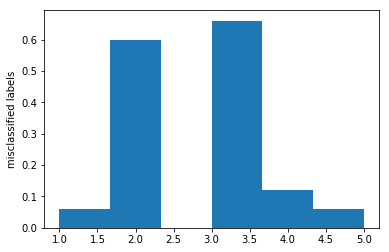

In [182]:
plt.hist(err_test_img_true_y, normed=True, bins=6)
plt.ylabel('misclassified labels')

In [154]:
def show_err_img(i):
    print('true label:{} pred label:{}'.format(err_test_img_true_y[i], err_test_img_pred_y[i]))
    img = Image.fromarray(train_img_x[i])
    return img

true label:2 pred label:4


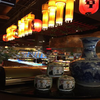

In [155]:
img = show_err_img(0)
img

true label:3 pred label:4


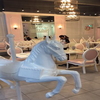

In [156]:
img = show_err_img(1)
img

true label:3 pred label:4


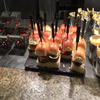

In [157]:
img = show_err_img(2)
img

true label:3 pred label:4


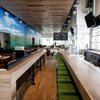

In [158]:
img = show_err_img(3)
img

true label:2 pred label:4


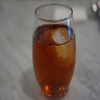

In [159]:
img = show_err_img(4)
img

true label:5 pred label:4


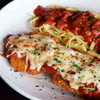

In [160]:
img = show_err_img(5)
img

true label:2 pred label:4


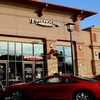

In [161]:
img = show_err_img(6)
img

true label:2 pred label:4


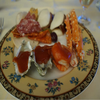

In [162]:
img = show_err_img(7)
img

true label:2 pred label:4


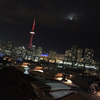

In [163]:
img = show_err_img(8)
img

true label:2 pred label:3


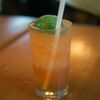

In [164]:
img = show_err_img(9)
img

true label:3 pred label:4


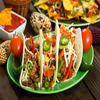

In [165]:
img = show_err_img(10)
img

true label:3 pred label:4


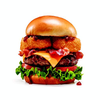

In [166]:
img = show_err_img(11)
img

true label:2 pred label:4


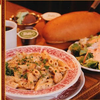

In [167]:
img = show_err_img(12)
img

true label:3 pred label:2


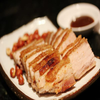

In [168]:
img = show_err_img(13)
img

true label:1 pred label:4


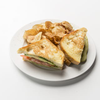

In [169]:
img = show_err_img(14)
img

true label:2 pred label:4


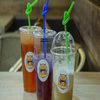

In [170]:
img = show_err_img(15)
img

true label:3 pred label:4


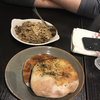

In [171]:
img = show_err_img(16)
img

true label:4 pred label:3


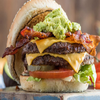

In [172]:
img = show_err_img(17)
img

true label:4 pred label:2


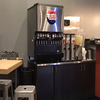

In [173]:
img = show_err_img(18)
img

true label:3 pred label:4


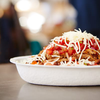

In [174]:
img = show_err_img(19)
img

true label:2 pred label:4


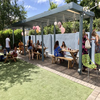

In [175]:
img = show_err_img(20)
img

true label:3 pred label:2


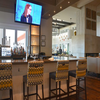

In [176]:
img = show_err_img(21)
img

true label:3 pred label:4


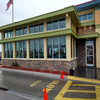

In [177]:
img = show_err_img(22)
img

true label:3 pred label:4


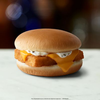

In [178]:
img = show_err_img(23)
img

true label:2 pred label:4


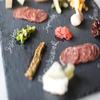

In [179]:
img = show_err_img(24)
img